## Running experiments for May6th meeting

In [1]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(416,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [3]:
def runNAgents(function, runs, store=False, freeze=0, ref=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='FourRooms-Goal-9', freeze=freeze, ref=ref)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [4]:
class DQN():
    def __init__(self, weights_loc, game='FourRooms-Goal-9'):
        config = Config()
        config.game = game
        config.task_fn = lambda: Task(config.game)
        config.eval_env = config.task_fn()
        self.network = VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(416,)))
        self.network.load_state_dict(torch.load(weights_loc))
    
agents = []
for i in tqdm(range(104)):
    agents.append(DQN('storage/DQN-FourRooms-Goal-'+str(i)+'.weights'))

In [61]:
def avdsr_feature(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), hidden_units=()) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(0.8, 0.8, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 2e5
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [66]:
env.render()

array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0, -2,  1],
       [ 1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1],
       [ 1,  0,  0,  0,  0,  0,  1,  0,  0, -1,  0,  0,  1],
       [ 1,  1,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,  1],
       [ 1,  0,  0,  0,  0,  0,  1,  1,  1,  0,  1,  1,  1],
       [ 1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1],
       [ 1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])

Text(0.5,1,'goal = 9')

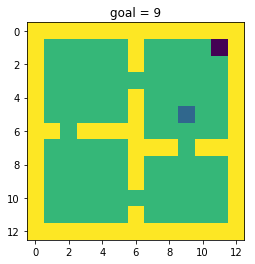

In [64]:
from deep_rl.component.fourrooms import FourRooms
env = FourRooms(goal=9)
state = env.reset()
plt.imshow(env.render())
plt.title('goal = ' + str(env.goal))

In [62]:
room_centers = [22, 38, 75, 91]
# room_centers = [22, 75, 91]
center_agents = []
for i in room_centers:
    center_agents.append(agents[i])

In [63]:
avdsr = avdsr_feature(game='FourRooms-Goal-9', agents=center_agents, choice=1)

2020-05-06 13:26:27,022 - root - INFO: steps 0, 190650181.82 steps/s
2020-05-06 13:26:28,112 - root - INFO: steps 1000, 920.38 steps/s
2020-05-06 13:26:29,120 - root - INFO: steps 2000, 994.84 steps/s
2020-05-06 13:26:30,393 - root - INFO: steps 3000, 786.43 steps/s
2020-05-06 13:26:31,315 - root - INFO: steps 4000, 1087.09 steps/s
2020-05-06 13:26:32,266 - root - INFO: steps 5000, 1053.93 steps/s
2020-05-06 13:26:33,272 - root - INFO: steps 6000, 996.77 steps/s
2020-05-06 13:26:34,420 - root - INFO: steps 7000, 871.80 steps/s
2020-05-06 13:26:35,481 - root - INFO: steps 8000, 945.81 steps/s
2020-05-06 13:26:36,474 - root - INFO: steps 9000, 1009.28 steps/s
2020-05-06 13:26:37,448 - root - INFO: steps 10000, 1028.41 steps/s
2020-05-06 13:26:38,407 - root - INFO: steps 11000, 1045.11 steps/s
2020-05-06 13:26:39,467 - root - INFO: steps 12000, 945.21 steps/s
2020-05-06 13:26:40,475 - root - INFO: steps 13000, 994.42 steps/s
2020-05-06 13:26:41,785 - root - INFO: steps 14000, 764.65 steps

2020-05-06 13:28:52,428 - root - INFO: steps 122000, 707.54 steps/s
2020-05-06 13:28:53,632 - root - INFO: steps 123000, 832.55 steps/s
2020-05-06 13:28:54,982 - root - INFO: steps 124000, 742.22 steps/s
2020-05-06 13:28:56,323 - root - INFO: steps 125000, 746.69 steps/s
2020-05-06 13:28:58,059 - root - INFO: steps 126000, 576.87 steps/s
2020-05-06 13:28:59,294 - root - INFO: steps 127000, 811.88 steps/s
2020-05-06 13:29:00,758 - root - INFO: steps 128000, 684.12 steps/s
2020-05-06 13:29:02,370 - root - INFO: steps 129000, 621.16 steps/s
2020-05-06 13:29:03,693 - root - INFO: steps 130000, 757.76 steps/s
2020-05-06 13:29:05,540 - root - INFO: steps 131000, 542.26 steps/s
2020-05-06 13:29:06,819 - root - INFO: steps 132000, 784.63 steps/s
2020-05-06 13:29:08,286 - root - INFO: steps 133000, 683.35 steps/s
2020-05-06 13:29:09,446 - root - INFO: steps 134000, 863.91 steps/s
2020-05-06 13:29:10,629 - root - INFO: steps 135000, 847.45 steps/s
2020-05-06 13:29:11,730 - root - INFO: steps 136

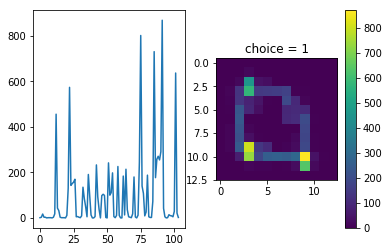

1


In [50]:
state = np.zeros(len(avdsr.replay.data))
for i in range(len(avdsr.replay.data)):
    state[i] = np.argmax(avdsr.replay.data[i][0])
counts = np.zeros(104)
for i in range(len(avdsr.replay.data)):
    counts[int(state[i])] += 1
plt.subplot(121)
plt.plot(counts)
plt.subplot(122)
visualize_vector(counts, title='choice = '+str(avdsr.choice))
print(avdsr.choice)

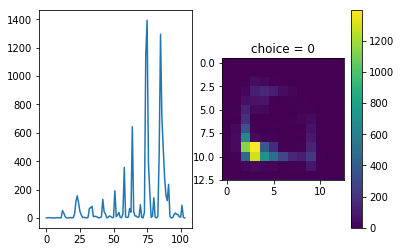

In [15]:
len(avdsr.actor.agents)

3

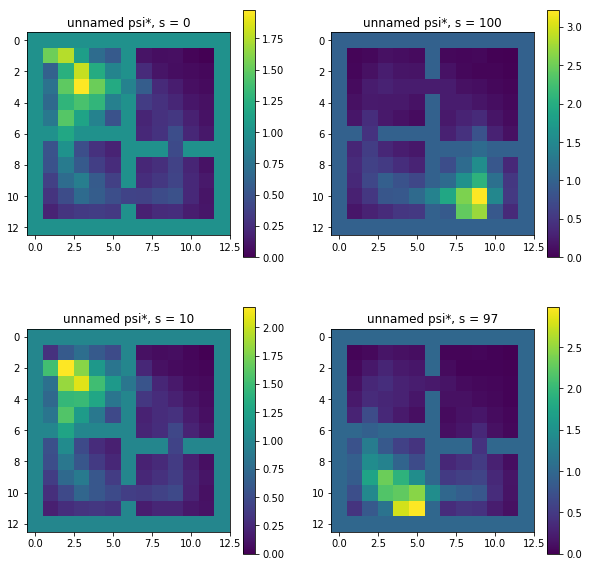

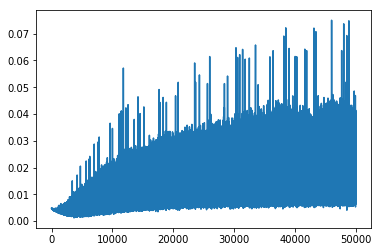

In [16]:
sanity_psi(avdsr)
plt.show()
plt.plot(avdsr.loss_vec)

In [17]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        agent.network.load_state_dict(ref.network.state_dict())
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent

def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(416,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [18]:
# r_dsr_init_dqns_4rooms_c0 = runNAgents(dsr_feature_init, runs=5, freeze=2, ref=avdsr) 
# r_dsr_init_dqns = runNAgents(dsr_feature_init, runs=5, freeze=2, ref=avdsr) 
# r_dsr_init_rand = runNAgents(dsr_feature_init, runs=5, freeze=2, ref=avdsr)
r_dsr_init_ood_c0 = runNAgents(dsr_feature_init, runs=5, freeze=2, ref=avdsr)
r_dqn_base = runNAgents(dqn_feature, runs=5)

2020-05-06 07:21:19,061 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-05-06 07:21:29,357 - root - INFO: steps 5000, episodic_return_test -180.00(18.97)
2020-05-06 07:21:39,094 - root - INFO: steps 10000, episodic_return_test -200.00(0.00)
2020-05-06 07:21:48,825 - root - INFO: steps 15000, episodic_return_test -200.00(0.00)
2020-05-06 07:21:59,991 - root - INFO: steps 20000, episodic_return_test -200.00(0.00)
2020-05-06 07:22:14,377 - root - INFO: steps 25000, episodic_return_test -200.00(0.00)
2020-05-06 07:22:24,829 - root - INFO: steps 30000, episodic_return_test -200.00(0.00)
2020-05-06 07:22:34,056 - root - INFO: steps 35000, episodic_return_test -200.00(0.00)
2020-05-06 07:22:42,344 - root - INFO: steps 40000, episodic_return_test -200.00(0.00)
2020-05-06 07:22:50,941 - root - INFO: steps 45000, episodic_return_test -200.00(0.00)
2020-05-06 07:23:00,357 - root - INFO: steps 50000, episodic_return_test -180.00(18.97)
2020-05-06 07:23:01,803 - root - INFO: steps 0

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/mnt/c/Users/Surya Penmetsa/Desktop/McGill Courses/Thesis/code/DeepRL/deep_rl/component/replay.py", line 127, in run
    op, data = self.worker_pipe.recv()
  File "/mnt/c/Users/Surya Penmetsa/Desktop/McGill Courses/Thesis/code/DeepRL/deep_rl/component/replay.py", line 127, in run
    op, data = self.worker_pipe.recv()
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/surya/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File 

KeyboardInterrupt: 

In [104]:
def plot_rewards(rewards, plot_seperate=True , clip=50000, title='unnamed'):
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(18,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = np.interp(np.arange(clip), t, r)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(convolve(mean,1000), label=k, color=colors[j])
#         plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

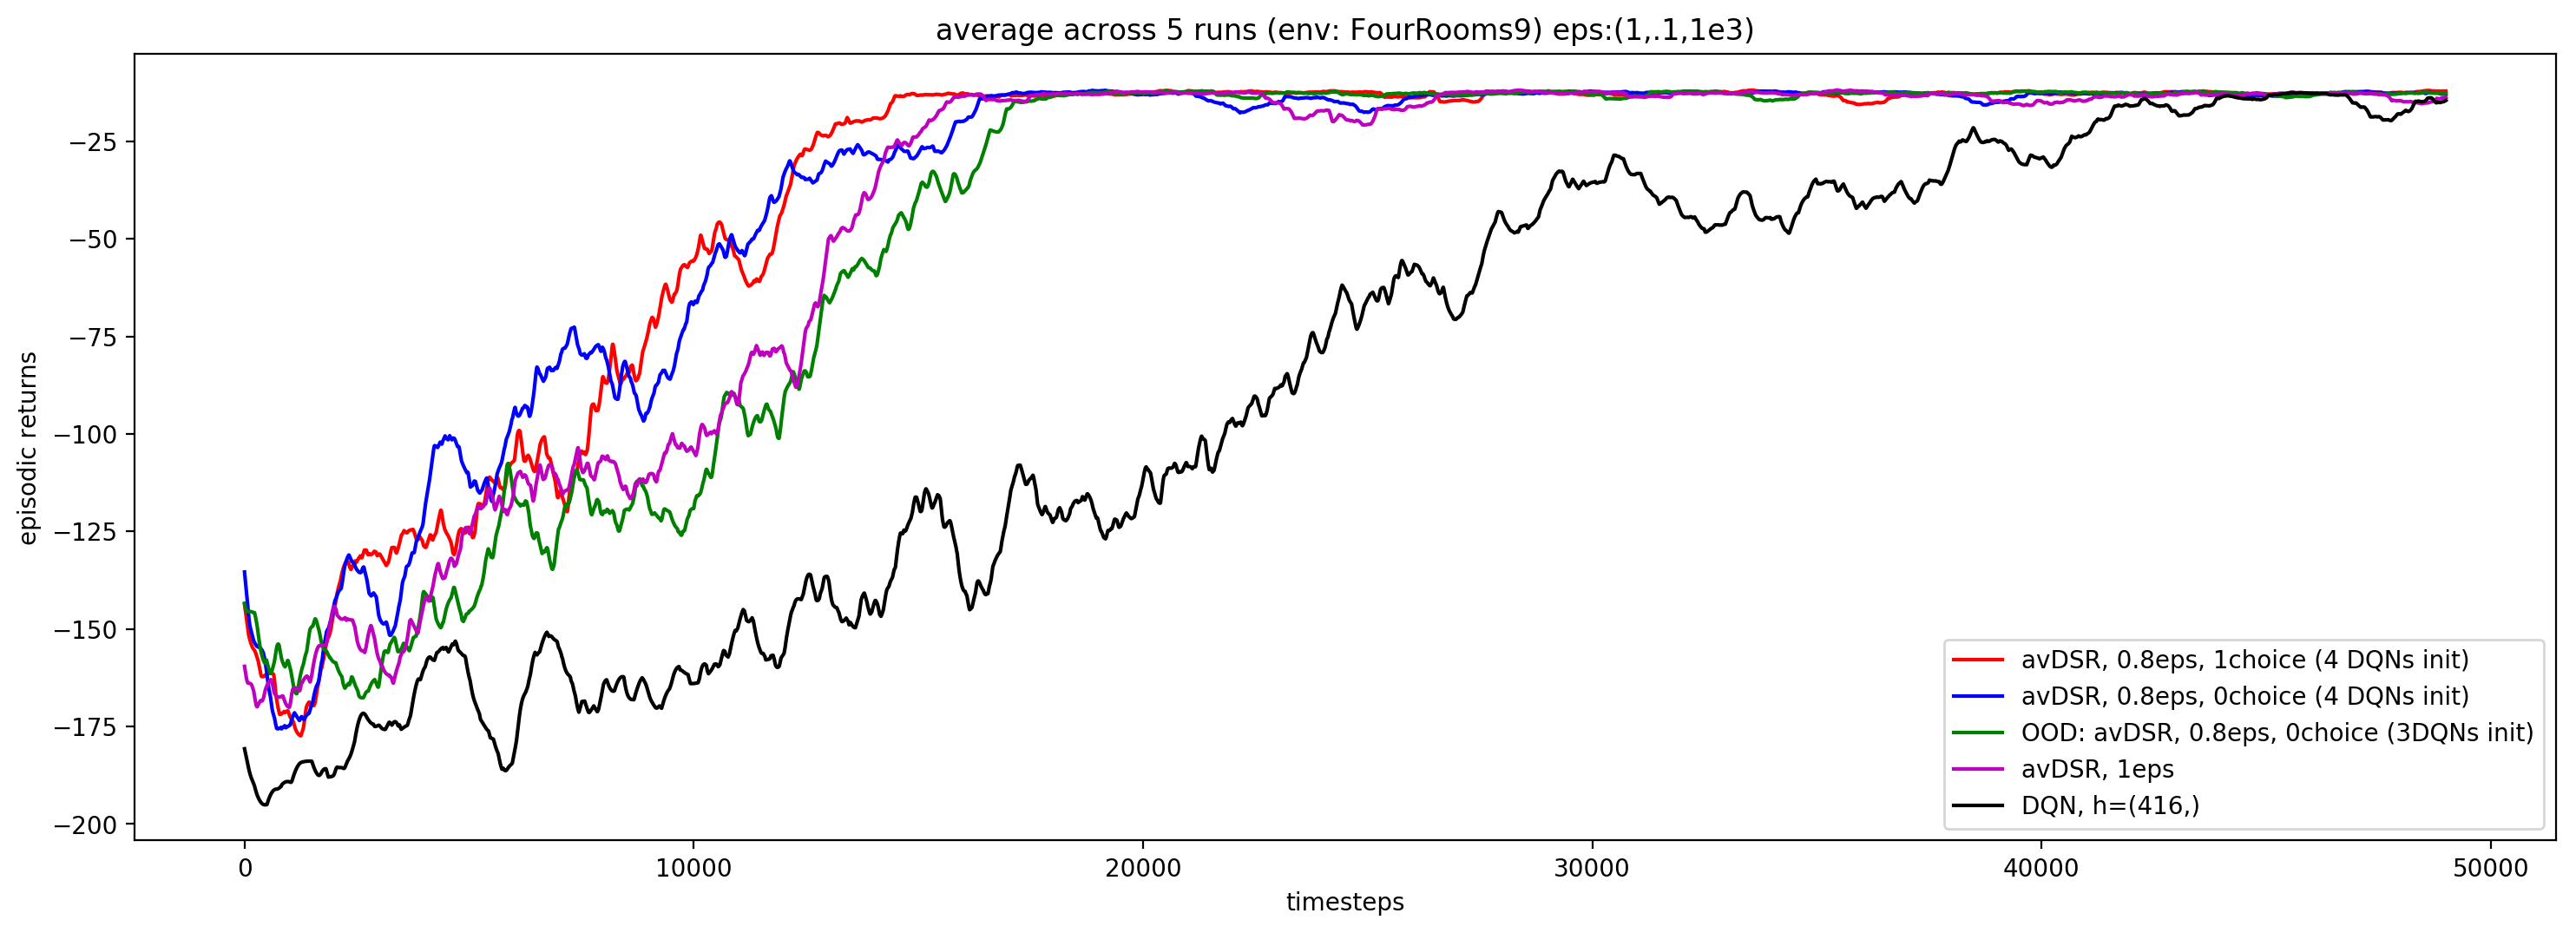

In [105]:
rewards_dict = {'avDSR, 0.8eps, 1choice (4 DQNs init)':r_dsr_init_dqns_4rooms_c1,
                'avDSR, 0.8eps, 0choice (4 DQNs init)':r_dsr_init_dqns_4rooms_c0,
                'OOD: avDSR, 0.8eps, 0choice (3DQNs init)': r_dsr_init_ood_c0,
                'avDSR, 1eps':r_dsr_init_rand,
                'DQN, h=(416,)': r_dqn_base}
# plot_rewards(rewards_dict, plot_seperate=True)
plot_rewards(rewards_dict, plot_seperate=False, title='average across 5 runs (env: FourRooms9) eps:(1,.1,1e3)')

(104, 2)


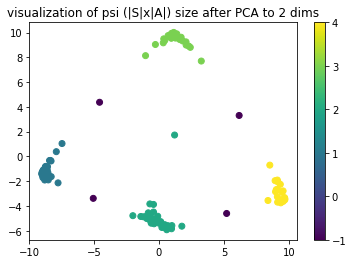

In [106]:
from sklearn.decomposition import PCA

def dimenRed(vis_agent):
    """
    Function to reduce the dimensionality of the psi(s,a) representations learnt,
    and visualizing them.
    """
    state_space = np.identity(104)
    c = np.ones(104)*4
    room1 = list(range(5)) + list(range(10,15)) + list(range(20,25)) + list(range(31,36)) +list(range(41,46))
    room2 = list(range(5,10)) + list(range(15,20)) + list(range(26,31)) + list(range(36,41)) + list(range(46,51)) + list(range(52,57))
    room3 = list(range(57,62)) + list(range(63,68)) + list(range(73,78)) + list(range(83,88)) + list(range(94,99))
    connect = [25, 51, 62, 88]
    c[room1] = 1
    c[room2] = 2
    c[room3] = 3
    c[connect] = [-1, -1, -1, -1]
    
    _, psi, _ = vis_agent.network(tensor(state_space))
    psi = psi.view(104,-1).detach().numpy()
    pca = PCA(n_components=2)
    k = pca.fit_transform(psi)
    print(k.shape)
    plt.scatter(k[:,0],k[:,1],c=c)
    plt.colorbar()
    plt.title('visualization of psi (|S|x|A|) size after PCA to 2 dims')
    
    
def dimenRed2(vis_agent, act_agent):
    """
    Function to reduce the dimensionality of the psi* representations learnt,
    and visualizing them.
    NOTE: psi*, where are the optimal actions picked from matters. act_agent 
    is used here.
    """
    state_space = np.identity(104)
    
    _, psi, _ = vis_agent.network(tensor(state_space))
    
    if('DSR' in str(type(act_agent))):
        _, _, q = act_agent.network(tensor(state_space))
    else:
        q = act_agent.network(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy()
    
    pass

dimenRed(avdsr)